## Tobacco Use and Mortality Prediction Project

## Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve
)

## Load the dataset

In [2]:
df = pd.read_csv(r"C:\Users\visma\Downloads\admissions.csv")
df.head()

,Year,ICD10 Code,ICD10 Diagnosis,Diagnosis Type,Metric,Sex,Value
0,2014/15,All codes,All admissions,All admissions,Number of admissions,NaN,11011882
1,2014/15,C33-C34 & C00-C14 & C15 & C32 & C53 & C67 & C6...,All diseases which can be caused by smoking,All diseases which can be caused by smoking,Number of admissions,NaN,1713330
2,2014/15,C00-D48,All cancers,All cancers,Number of admissions,NaN,1691035
3,2014/15,J00-J99,All respiratory diseases,All respiratory diseases,Number of admissions,NaN,611002
4,2014/15,I00-I99,All circulatory diseases,All circulatory diseases,Number of admissions,NaN,907157


In [3]:
df.shape

(2079, 7)

##  Initial Exploration

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2079 entries, 0 to 2078
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Year             2079 non-null   object
 1   ICD10 Code       2079 non-null   object
 2   ICD10 Diagnosis  2079 non-null   object
 3   Diagnosis Type   2079 non-null   object
 4   Metric           2079 non-null   object
 5   Sex              1386 non-null   object
 6   Value            2078 non-null   object
dtypes: object(7)
memory usage: 113.8+ KB
None


In [5]:
print(df.head())

      Year                                         ICD10 Code  \
0  2014/15                                          All codes   
1  2014/15  C33-C34 & C00-C14 & C15 & C32 & C53 & C67 & C6...   
2  2014/15                                            C00-D48   
3  2014/15                                            J00-J99   
4  2014/15                                            I00-I99   

                               ICD10 Diagnosis  \
0                               All admissions   
1  All diseases which can be caused by smoking   
2                                  All cancers   
3                     All respiratory diseases   
4                     All circulatory diseases   

                                Diagnosis Type                Metric  Sex  \
0                               All admissions  Number of admissions  NaN   
1  All diseases which can be caused by smoking  Number of admissions  NaN   
2                                  All cancers  Number of admissions  NaN   


In [6]:
print(df.isnull().sum())

Year                 0
ICD10 Code           0
ICD10 Diagnosis      0
Diagnosis Type       0
Metric               0
Sex                693
Value                1
dtype: int64


In [7]:
df.describe()

,Year,ICD10 Code,ICD10 Diagnosis,Diagnosis Type,Metric,Sex,Value
count,2079,2079,2079,2079,2079,1386,2078
unique,11,32,32,11,2,2,1420
top,2014/15,All codes,All admissions,Cancers which can be caused by smoking,Number of admissions,Male,.
freq,189,66,66,726,1056,693,40


## Data Cleaning

In [8]:
df = df.dropna(subset=['Value'])

In [9]:
df['Sex'] = df['Sex'].fillna('Unknown')

In [10]:
df['Value'] = pd.to_numeric(df['Value'], errors='coerce')

In [11]:
df = df.dropna(subset=['Value'])

## Feature Engineering

In [12]:
df['Year'] = df['Year'].astype(str).str.extract(r'(\d{4})')

In [13]:
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

In [14]:
df = df.dropna(subset=['Year'])

In [15]:
df['Year'] = df['Year'].astype(int)

In [16]:
categorical_cols = ['ICD10 Code', 'ICD10 Diagnosis', 'Diagnosis Type', 'Metric', 'Sex']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [17]:
threshold = df['Value'].median()
df['mortality'] = (df['Value'] > threshold).astype(int)
df = df.drop('Value', axis=1)

## EDA - Exploratory Data Analysis

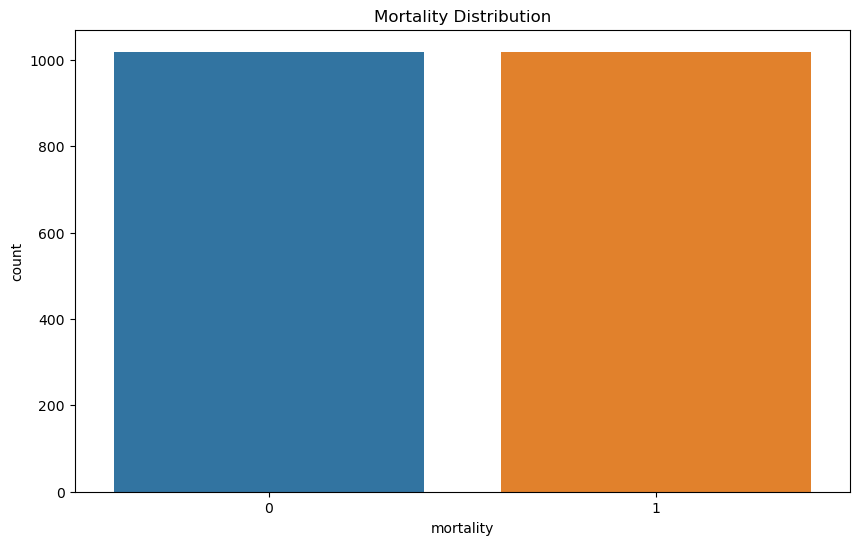

In [18]:
plt.figure(figsize=(10, 6))
sns.countplot(x='mortality', data=df)
plt.title('Mortality Distribution')
plt.show()

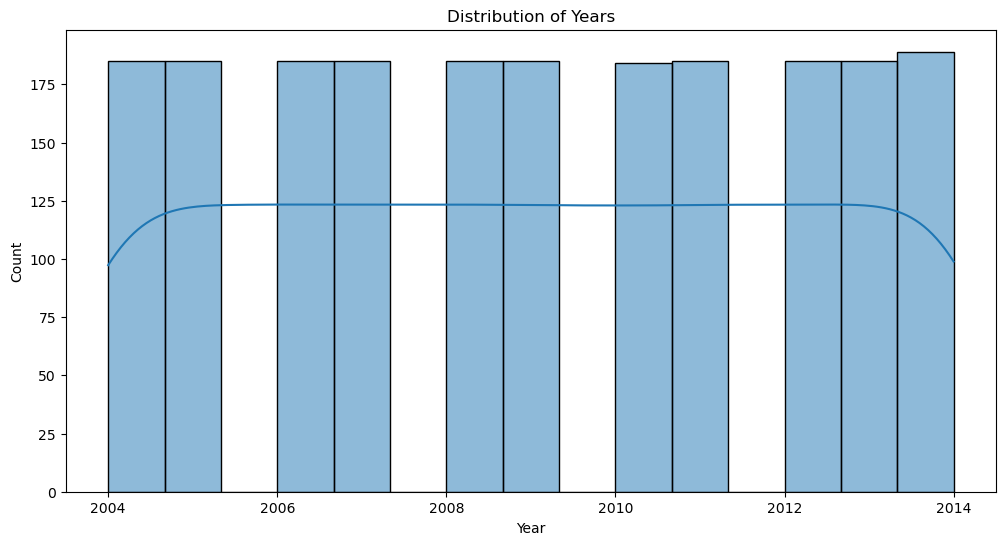

In [19]:
plt.figure(figsize=(12, 6))
sns.histplot(df['Year'], bins=15, kde=True)
plt.title('Distribution of Years')
plt.show()

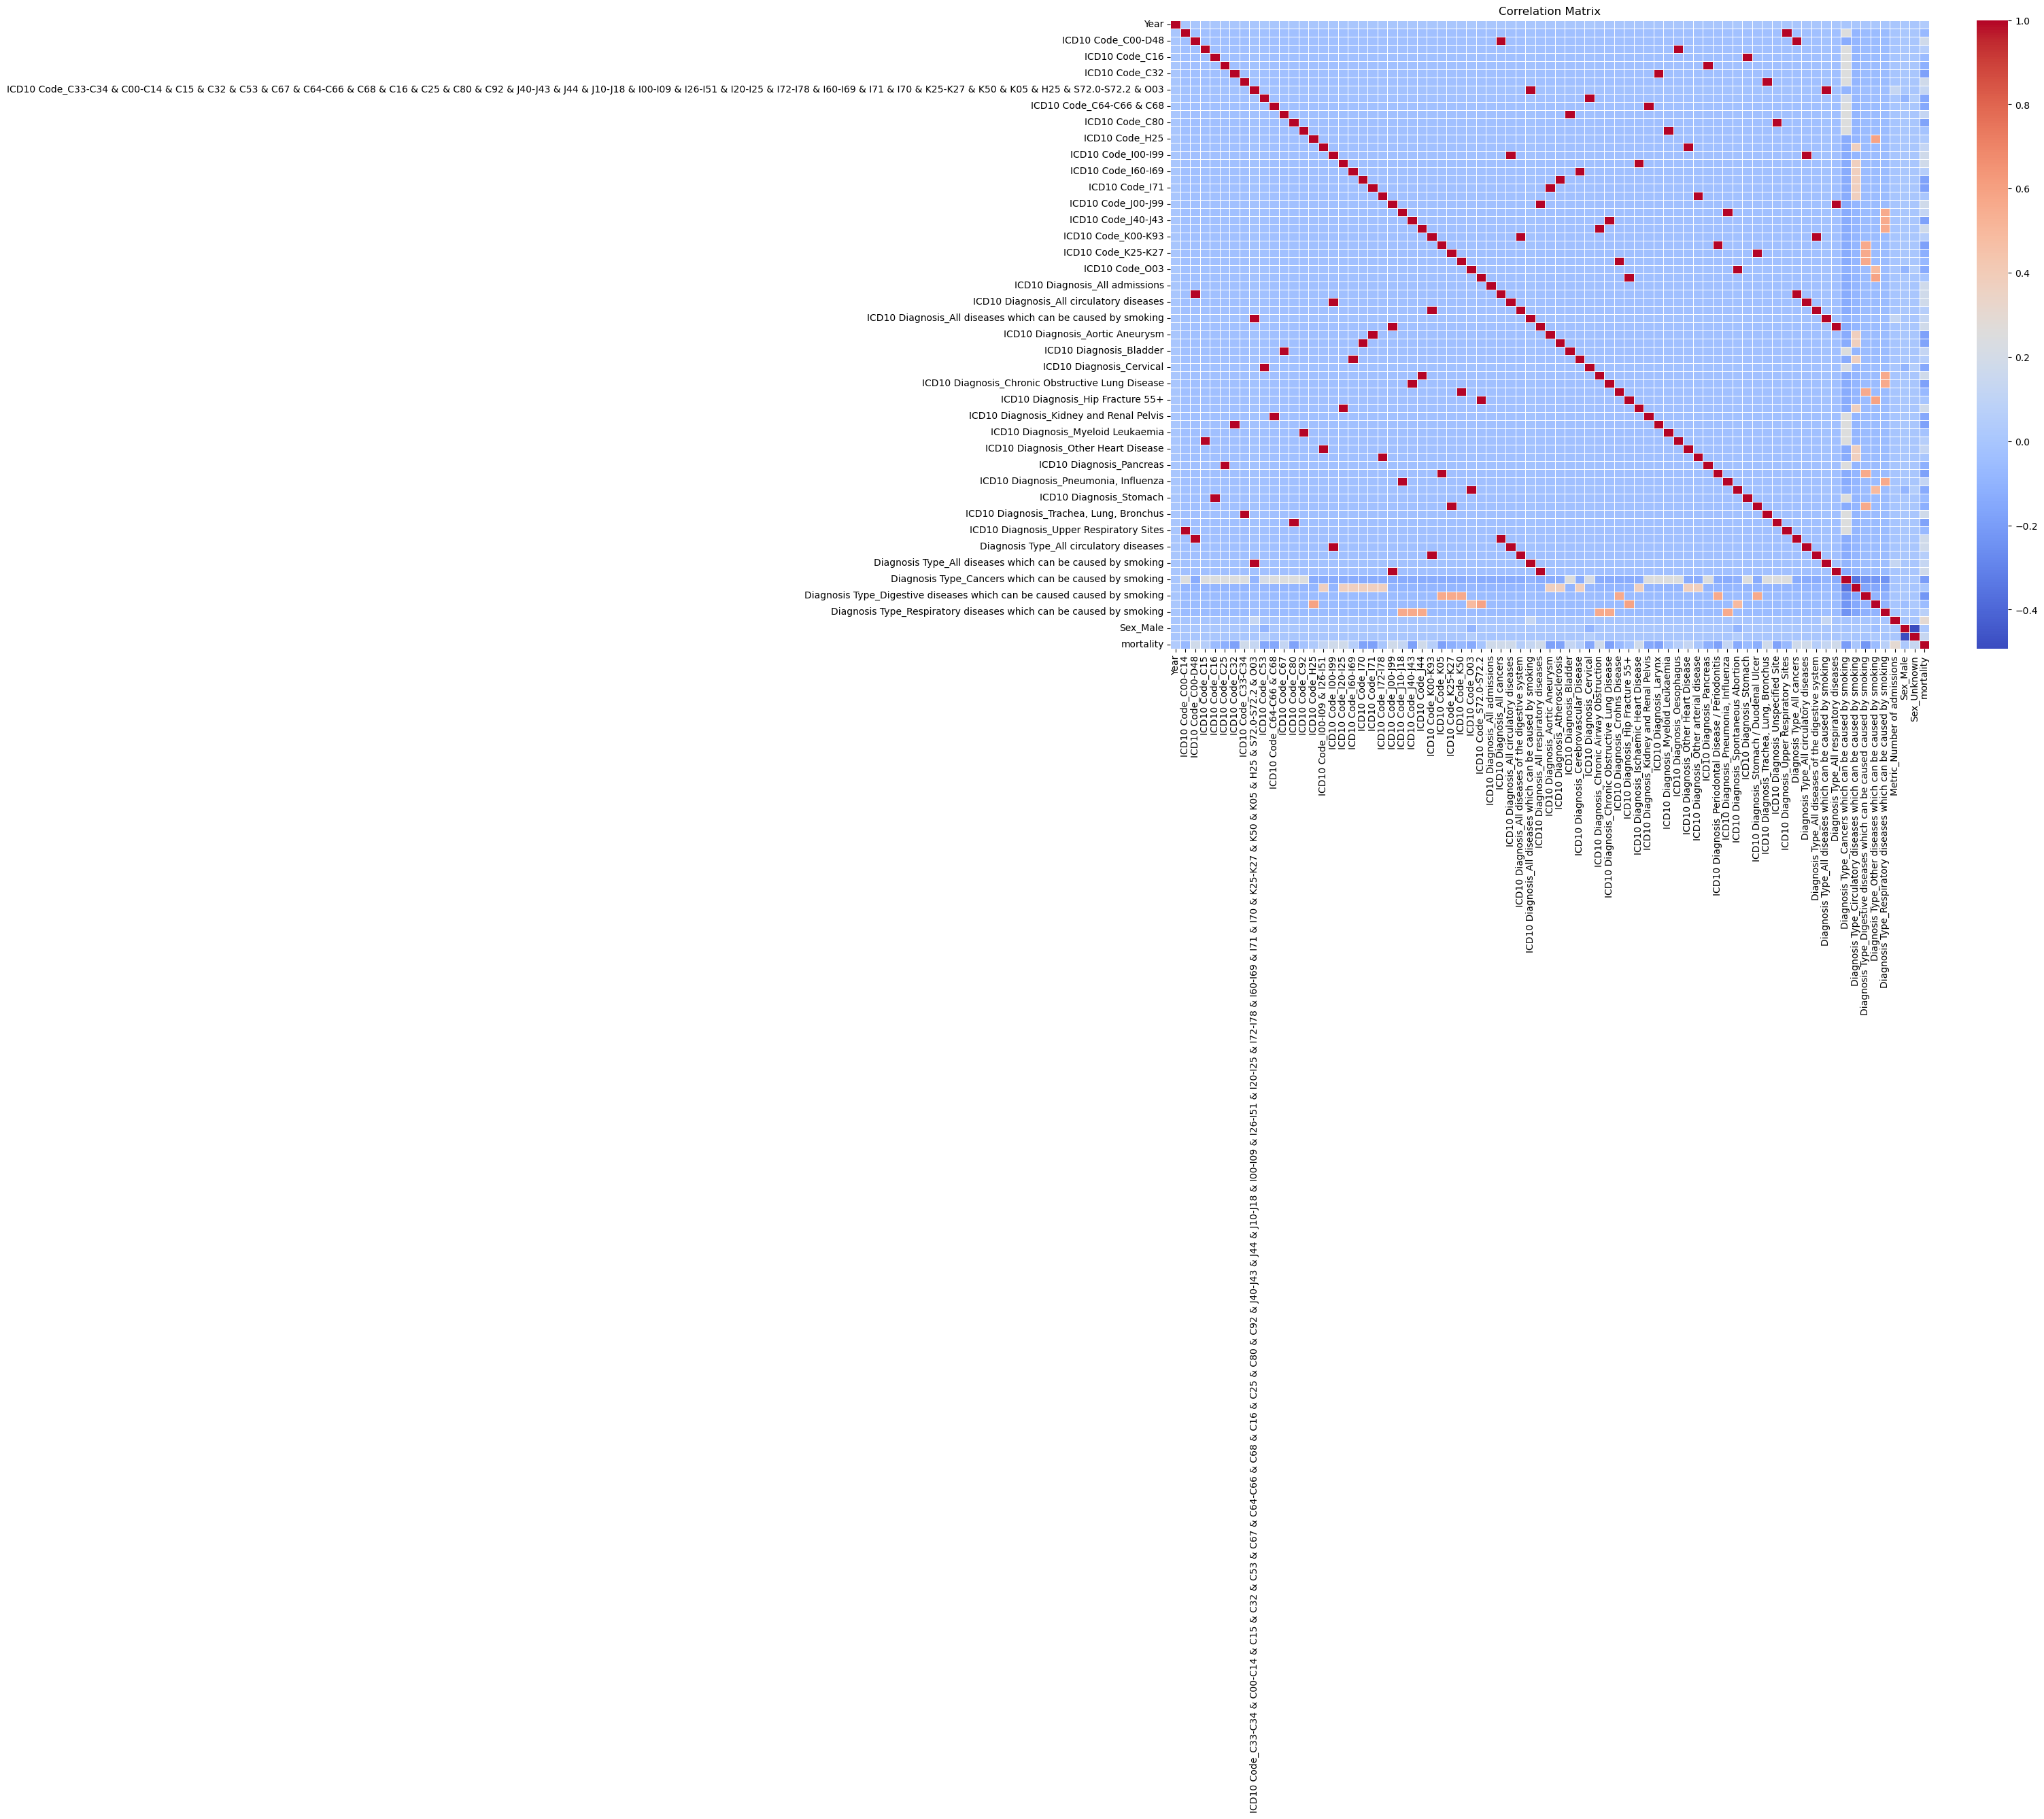

In [20]:
plt.figure(figsize=(18, 12))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## Split Data

In [21]:
X = df.drop('mortality', axis=1)
y = df['mortality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Standardize Features

In [22]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Train Models

In [23]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
log_reg_pred = log_reg.predict(X_test)

In [24]:
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)
rf_clf_pred = rf_clf.predict(X_test)

## Evaluate Models

In [25]:
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n{model_name} Metrics")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
    print(f"ROC AUC: {roc_auc_score(y_true, y_pred):.4f}")

In [26]:
evaluate_model(y_test, log_reg_pred, "Logistic Regression")
evaluate_model(y_test, rf_clf_pred, "Random Forest")


Logistic Regression Metrics
Accuracy: 0.9706
Precision: 0.9792
Recall: 0.9592
F1 Score: 0.9691
ROC AUC: 0.9702

Random Forest Metrics
Accuracy: 0.9902
Precision: 1.0000
Recall: 0.9796
F1 Score: 0.9897
ROC AUC: 0.9898


## Save SHAP and ROC plots

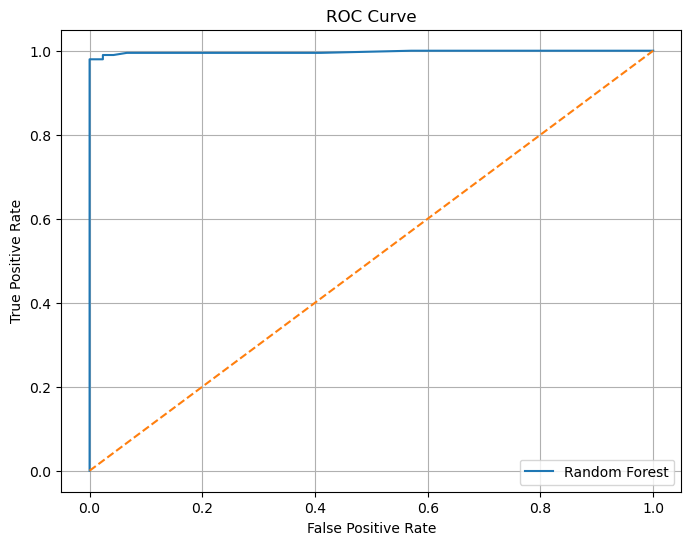

In [27]:
if not os.path.exists('shap'):
    os.makedirs('shap')

y_probs = rf_clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Random Forest')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.savefig('shap/roc_curve.png')
plt.show()

C:\Users\visma\anaconda3\a3\5555\Lib\site-packages\shap\plots\_beeswarm.py:1153: UserWarning: The figure layout has changed to tight
  pl.tight_layout()
C:\Users\visma\anaconda3\a3\5555\Lib\site-packages\shap\plots\_beeswarm.py:761: UserWarning: The figure layout has changed to tight
  pl.tight_layout(pad=0, w_pad=0, h_pad=0.0)


<Figure size 640x480 with 0 Axes>

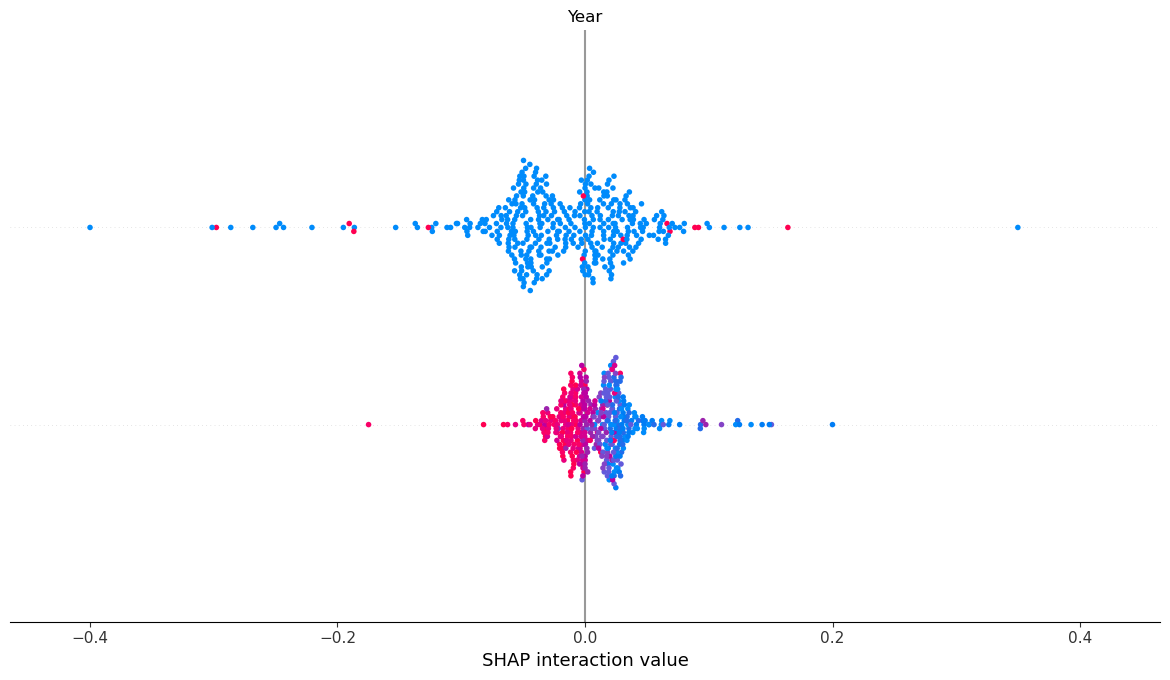

In [28]:
explainer = shap.Explainer(rf_clf, X_train)
shap_values = explainer(X_test, check_additivity=False)
shap.summary_plot(shap_values, X_test, feature_names=X.columns, show=False)
plt.savefig('shap/shap_summary.png', bbox_inches='tight')
plt.show()

## Save Model and Scaler

In [29]:
if not os.path.exists('app'):
    os.makedirs('app')

joblib.dump(rf_clf, 'app/mortality_model.pkl')
joblib.dump(scaler, 'app/scaler.pkl')

['app/scaler.pkl']

## Prepare Sample Input

In [30]:
sample_input = X_test[0].tolist()
print("\n✅ Sample Input (JSON Ready):")
print(sample_input)


✅ Sample Input (JSON Ready):
[-0.6468608955118581, -0.18510526570268865, -0.18332516651358935, -0.18862169772821866, -0.18510526570268865, -0.18687063686046268, -0.17418765764500468, -0.18687063686046268, -0.12480514407482948, -0.15240280983943644, -0.18510526570268865, -0.17230920216203122, -0.18862169772821866, 5.50873432343164, -0.17041245271518168, -0.18332516651358935, -0.19379292300874917, -0.18687063686046268, -0.18152990165934432, -0.17604840918974993, -0.18510526570268865, -0.18152990165934432, -0.17789201674120503, -0.18862169772821866, -0.18152990165934432, -0.17418765764500468, -0.18510526570268865, -0.1760484091897499, -0.19035884739603076, -0.18510526570268865, -0.15028204349568727, -0.18862169772821866, -0.18152990165934432, -0.18332516651358935, -0.19379292300874917, -0.18510526570268865, -0.12480514407482948, -0.17789201674120503, -0.18510526570268865, -0.17604840918974993, -0.17230920216203122, -0.18152990165934432, -0.15240280983943644, -0.17418765764500468, -0.1815